In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import gurobipy as gp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Read in the data

In [49]:
train = pd.read_csv('training_data.csv')
test = pd.read_csv('test_data.csv')

### Split the data into independent and target variables

In [60]:
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

### Select the values for k, Big-M, cross-validation folds and the Gurobi time limit

In [61]:
M = 20
k = [i for i in range(5,55,5)]
limit = 3600
folds = 10

### Function to minimze Sum of Squared Errors by selecting 'k' optimal features for the model using Gurobi

In [62]:
def min_sse(X_train, X_test, y_train, y_test, k):

    '''
    A function to return the sum of squared errors after predicting on test set, by selecting 'k' optimal independent variables 
    to predict target variable.
    
    Parameters:
    training, test independent and target variables, number of features 'k' to select in the model
    
    Returns:
    Sum of squared errors for the test set
    
    '''
    
    X = X_train.copy()
    m = X.shape[1]
    X.insert(0, 'X0', np.ones(X_train.shape[0]))
    L = np.concatenate((np.array(-2*y_train.T@X),np.array([0]*m)))
    
    Q = np.zeros(((2*m)+1,(2*m)+1))
    Q[0:m+1,0:m+1] = X.T@X
    
    A = np.zeros((L.shape[0],2*m+1))
    b = np.zeros((A.shape[0]))
    
    for i in range(A.shape[0]): # A.shape[0] = 101  i = 0 to i = 100
        if i < m: #X.shape[1] = 51 i = 0 to i = 50
            A[i,i+1] = 1 #A[0,1] = 1
            A[i,i+m+1] = -M #A[0,0+51] = A[0,51]
            A[i+m,i+1] = -1
            A[i+m,i+m+1] = -M
            b[i] = 0
        elif i == (2*m): #A.shape[0] - 1 = 101 - 1 = 100 i=100
            A[i,m+1:] = 1
            b[i] = k

    sense = np.array(["<"]*(A.shape[0]))
    vtype = ['C']*(m+1) + ['B']*m
    lb = [-M]*(m+1) + [0]*m
    ub = [M]*(m+1) + [1]*m
    
    regMod = gp.Model()
    regMod_x = regMod.addMVar(len(L),vtype=vtype,lb=lb,ub=ub)
    regMod_con = regMod.addMConstrs(A, regMod_x, sense, b)
    regMod.setMObjective(Q,L,0,sense=gp.GRB.MINIMIZE)
    regMod.Params.OutputFlag = 0
    regMod.Params.TimeLimit = limit
    regMod.optimize()

    beta = regMod_x.x[:m+1]
    print(X.columns[beta!=0].values[1:])
    
    X_test.insert(0,'X0',np.ones(X_test.shape[0]))
    print(f'SSE: {np.sum(((X_test @ beta) - y_test)**2)}')
    
    return np.sum(((X_test @ beta) - y_test)**2)

### Cross Validation on the dataset to identify best value of 'k' to pass to the gurobi optimizer

In [63]:
def cross_validation_test(X_train, X_test, y_train, y_test):
    
    '''
    A function to return the sum of squared errors for all 'k', along with the best value of k
    
    Parameters:
    training, test independent and target variables
    
    Returns:
    Sum of squared errors for all values of k, best k
    '''
    
    sse = np.zeros((folds, len(k)))

    for j in range(len(k)):
        print(f'\nk = {k[j]}:')

        idx = np.array([i for i in range(0,X_train.shape[0],1)])
        np.random.shuffle(idx)

        for i in range(folds):
            idx_lb = i*folds
            idx_ub = i*folds+folds
            X_ts = X_train.iloc[idx[idx_lb:idx_ub]]
            y_ts = y_train.iloc[idx[idx_lb:idx_ub]]

            mask = np.array([i not in idx[idx_lb:idx_ub] for i in idx], dtype=np.bool)
            idx_1 = np.array(idx)
            idx_1[mask]
            X_tr = X_train.iloc[idx_1[mask]]
            y_tr = y_train.iloc[idx_1[mask]]
            print(f'ITERATION {i}:')
            sse[i][j] = min_sse(X_tr, X_ts, y_tr, y_ts, k[j])

        sse_folds = np.mean(sse,axis=0)
    
    best_k = k[sse_folds.argmin()]
    print(best_k)
    
    return sse, sse_folds, best_k

In [14]:
sse, sse_folds, best_k = cross_validation_test(X_train, X_test, y_train, y_test)


k = 5:
ITERATION 0:
Academic license - for non-commercial use only - expires 2022-08-27
Using license file C:\Users\ssahi\gurobi.lic
SSE: 11.453052017446396
ITERATION 1:
SSE: 29.32986848348305
ITERATION 2:
SSE: 45.064814045402414
ITERATION 3:
SSE: 25.91111779404988
ITERATION 4:
SSE: 20.189390545508477
ITERATION 5:
SSE: 34.083014948929154
ITERATION 6:
SSE: 41.20519401411768
ITERATION 7:
SSE: 19.23163891710223
ITERATION 8:
SSE: 37.29963568253419
ITERATION 9:
SSE: 41.364274323177426

k = 10:
ITERATION 0:
SSE: 26.36028215269672
ITERATION 1:
SSE: 11.713023262533952
ITERATION 2:
SSE: 31.880655691580753
ITERATION 3:
SSE: 20.42420824558809
ITERATION 4:
SSE: 38.076709972358366
ITERATION 5:
SSE: 23.431306037330575
ITERATION 6:
SSE: 33.190372772265185
ITERATION 7:
SSE: 17.273786632156146
ITERATION 8:
SSE: 27.722090925378627
ITERATION 9:
SSE: 41.49200364775306

k = 15:
ITERATION 0:
SSE: 35.72389394318344
ITERATION 1:
SSE: 72.861911931339
ITERATION 2:
SSE: 41.81730220582846
ITERATION 3:
SSE: 29.19

In [17]:
pd.DataFrame(sse, columns=k,index=(range(folds))).to_csv('10foldCV.csv')

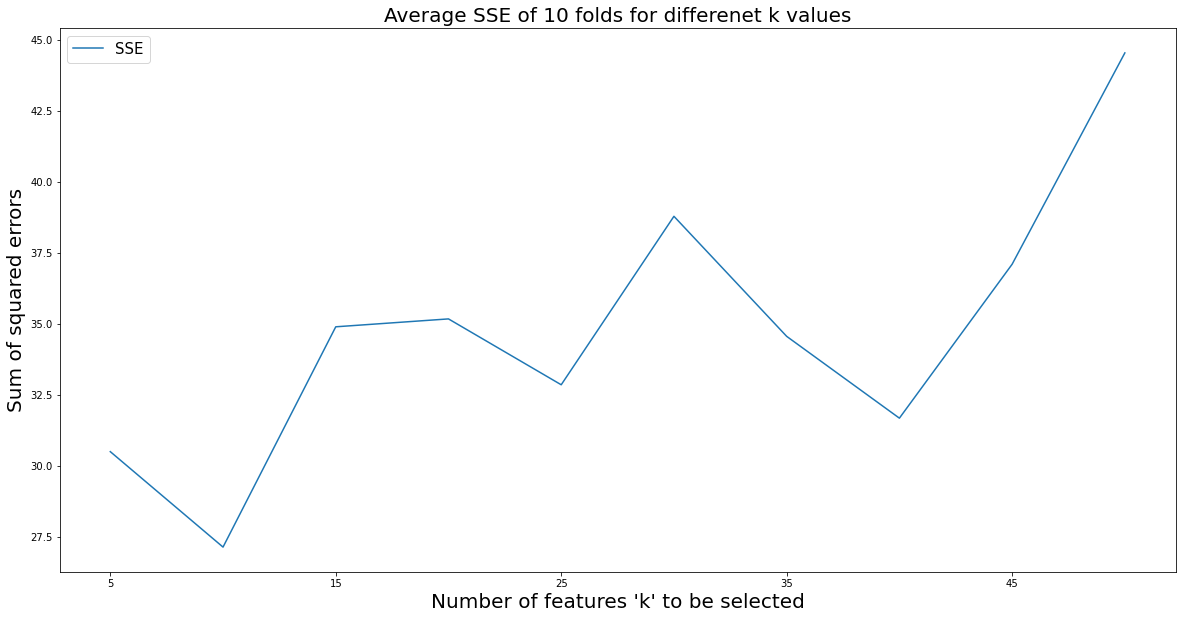

In [76]:
results = pd.read_csv('10foldCV.csv')
results.set_index('Unnamed: 0', inplace=True)
plt.figure(figsize=(20, 10))
np.mean(results,axis=0).plot(kind='line')
plt.title('Average SSE of 10 folds for differenet k values', fontsize=20)
plt.xlabel('Number of features \'k\' to be selected', fontsize=20)
plt.ylabel('Sum of squared errors', fontsize=20)
plt.legend(['SSE'], prop={'size': 15})

### Print the Least SSE and the best k after Cross-validation

In [100]:
print(f'Least SSE:{sse_folds.min()} for k:{best_k}')

Least SSE:27.15644393396415 for k:10


### Aggregated SSEs for each k value after Cross-validation

In [101]:
pd.DataFrame(sse_folds, columns=['SSE'], index=k)

,SSE
5,30.513200
10,27.156444
15,34.904315
20,35.181969
25,32.865494
30,38.790432
35,34.568680
40,31.691171
45,37.104564
50,44.537307


### Determine the SSE for the best k i.e, k=10

In [64]:
print('The features selected:\n')
sse_opt = min_sse(X_train, X_test, y_train, y_test, 10)
print(f'\nThe SSE for the test set for k=10: {sse_opt}')

The features selected:

['X9' 'X15' 'X16' 'X23' 'X24' 'X26' 'X34' 'X45' 'X47' 'X48']
SSE: 116.8271982276263

The SSE for the test set for k=10: 116.8271982276263


## Running LassoCV with 10 folds to determine best lambda and the SSE

In [65]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=10, random_state=0).fit(X_train, y_train)
coeffs = reg.coef_
print('The features selected by Lasso:\n')
print(X_train.columns[coeffs!=0])

print(f'Best lambda : {reg.alpha_}')
y_pred = reg.predict(X_test.iloc[:,1:])
sse_lasso = np.sum((y_pred - y_test)**2)
print(f'SSE for test data predictions is {sse_lasso}')

The features selected by Lasso:

Index(['X9', 'X11', 'X15', 'X16', 'X22', 'X23', 'X24', 'X26', 'X29', 'X33',
       'X34', 'X39', 'X44', 'X45', 'X46', 'X47', 'X48'],
      dtype='object')
Best lambda : 0.07638765995113507
SSE for test data predictions is 117.48173795802899


In [ ]:
print('Predicted Values:\n')
y_pred

Predicted Values:



array([ 6.07686351,  4.9181073 ,  3.22777954,  3.57138566, -0.41849943,
       -4.94878307, -2.8218873 , -1.49522305,  1.38296395, -0.24746403,
       -1.94701631,  2.70749465,  0.64484559, -0.50918617, -0.31915912,
        7.37584986, -7.54781954,  3.59673093, -4.39624331, -2.98890566,
       -1.94423698,  3.33248953, -2.42122798,  1.13315219, -2.53307168,
       -0.15595162, -1.62271875, -2.31420693, -3.46402012, -3.71707635,
       -1.66827581, -0.07491137,  1.40363987,  5.45269115, -1.20270399,
        2.37325349,  4.74719816,  3.13015173,  1.55100085,  5.85587702,
       -0.81232674,  4.66231732, -5.71548761, -1.20927664,  4.25279319,
        4.09734242,  3.8335482 ,  0.61787077,  1.89407804, -1.02592954])

In [56]:
print('Predicted Values:\n')
y_pred

Predicted Values:



array([ 6.07686351,  4.9181073 ,  3.22777954,  3.57138566, -0.41849943,
       -4.94878307, -2.8218873 , -1.49522305,  1.38296395, -0.24746403,
       -1.94701631,  2.70749465,  0.64484559, -0.50918617, -0.31915912,
        7.37584986, -7.54781954,  3.59673093, -4.39624331, -2.98890566,
       -1.94423698,  3.33248953, -2.42122798,  1.13315219, -2.53307168,
       -0.15595162, -1.62271875, -2.31420693, -3.46402012, -3.71707635,
       -1.66827581, -0.07491137,  1.40363987,  5.45269115, -1.20270399,
        2.37325349,  4.74719816,  3.13015173,  1.55100085,  5.85587702,
       -0.81232674,  4.66231732, -5.71548761, -1.20927664,  4.25279319,
        4.09734242,  3.8335482 ,  0.61787077,  1.89407804, -1.02592954])

### Comparing SSE of Optimization and Lasso:

In [81]:
pd.DataFrame([[sse_opt,best_k],[sse_lasso, reg.alpha_]], columns = ['SSE','k / lambda'], index=['Gurobi Optimizer','Lasso'])

,SSE,k / lambda
Gurobi Optimizer,116.827198,10.000000
Lasso,117.481738,0.076388
